In [32]:
# imports
import cv2 as cv
import numpy as np
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os, shutil
from shutil import copyfile
from distutils.dir_util import copy_tree
import xml.etree.ElementTree as ET
import pdb
import shutil
%matplotlib inline

In [33]:
# variables setting

input_height=128
input_width=96
list_size = 32
batch_size = 8


red_range = (1, random.randint(1,500))
blue_range = (1, random.randint(1,500))
green_range = (1, random.randint(1,500))

resize_height= (0.3,0.5)
resize_width= (0.3,0.5)

superpixel_p = (0.1, 1.0)
superpixel_n = (64, 256)

gau_blur_size = (0.0, 10.0)
avg_blur_size = (2, 17)
med_blur_size = (3,17)

sharpen_alpha=(0.0, 1.0)
sharpen_lightness=(0.0, 2.0)

add_size = (-50, 50)
add_per_channel_size = 0.6

emboss_alpha= (0.0, 1.0)
emboss_strength=(0.5, 1.5)

gaussian_noise=(0, 0.5*255)

multiply_scale= (0.5, 1.5)

dropout_p=(0, 0.4)

coarse_dropout = 0.2

contrast_normal_scale = (0, 1)

spnoise= (0.3, 300)

affine_translate_x=(-0.1, 0.1)
affine_translate_y=(-0.1, 0.1)
affine_rotate=(-45, 45)
affine_shear = (-16, 16)

piecewise_affine_scale= (0.01, 0.05)

elastic_alpha = (0, 5.0)
elastic_sigma = 0.25

### Load and display training images

Original: (128, 96, 4)


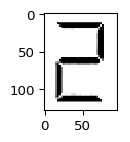

Image list:


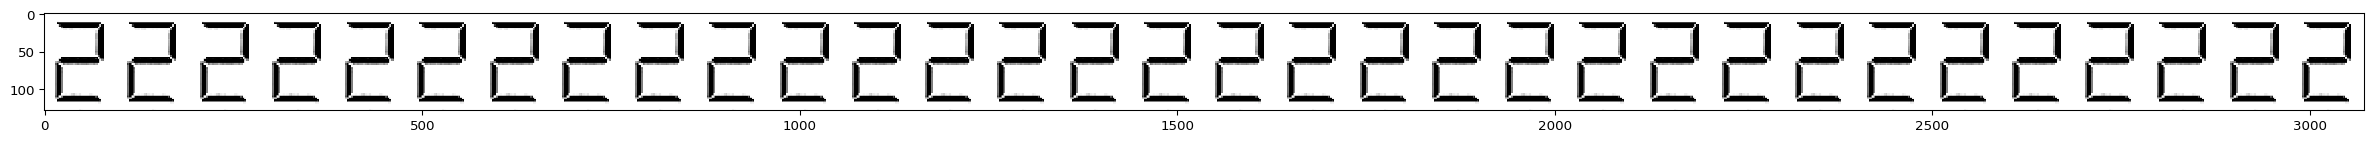

Image batch: 
Number of image in batch:  8


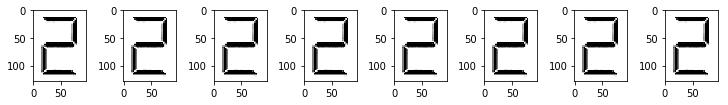

In [34]:
# example display
os.chdir('/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/')

# Load and display 
image = imageio.imread("./digit/002000.jpg")
image = cv.resize(image, (input_width,input_height), interpolation=cv.INTER_CUBIC)
print("Original:", image.shape)
ia.imshow(image)

# a list of images
images = []
for i in range(list_size):
    images.append(image)
print("Image list:")
ia.imshow(np.hstack(images))

# create a batch of images
images_batch = np.array(
    [image for _ in range(batch_size)],
    dtype=np.uint8
)
print("Image batch: ")
print("Number of image in batch: ", len(images_batch))
#ia.imshow(np.hstack(images_batch))
fig, ax = plt.subplots(1, batch_size, constrained_layout=True, figsize=(10,10))
for i in range (batch_size):
    ax[i].imshow(images_batch[i])

In [124]:
# check path
os.getcwd()

'/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display'

In [125]:
# plot the annotatition 

for img_name in os.listdir("/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/VOC2007/JPEGImages"):
    
    a,b = os.path.splitext(img_name)
    if b == '.jpg':
        img = cv.imread("./VOC2007/JPEGImages/" + img_name)
        
        cv.imshow('test', img)
        
        tree = ET.parse("./VOC2007/Annotations/" + a + '.xml')
        root = tree.getroot()
        for box in root.iter('bndbox'):
            x1= float(box.find('xmin').text)
            x2= float(box.find('xmax').text)
            y1= float(box.find('ymin').text)
            y2= float(box.find('ymax').text)
            
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            
            print(x1, x2, y1, y2)
            imgplot = plt.imshow(img)

            plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),linewidth=1,edgecolor='r',facecolor='none'))
            plt.show()
          

'/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display'

### Sequence of augmentation

In [35]:
# check current directory
os.getcwd()



'/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display'

In [36]:
# variables setting

input_height=128
input_width=96
list_size = 32
batch_size = 8

# red_range = (1, random.randint(1,200))
# blue_range = (1, random.randint(1,200))
# green_range = (1, random.randint(1,200))
red_range = (1, 200)
blue_range = (1, 200)
green_range = (1, 200)

resize_height= (0.3,0.5)
resize_width= (0.3,0.5)

superpixel_p = (0.1, 0.25)
superpixel_n = (32, 128)

gau_blur_size = (0.0, 3.0)
avg_blur_size = (2, 3)
med_blur_size = (3, 5)

sharpen_alpha=(0.0, 0.2)
sharpen_lightness=(0.0, 2.0)

emboss_alpha= (0.0, 0.2)
emboss_strength=(0.2, 0.4)

add_size = (-20, 20)
add_per_channel_size = 0.2

gaussian_noise=(0, 0.02*255)

multiply_scale= (0.9, 1.1)

dropout_p=(0, 0.2)

coarse_dropout = 0.02

contrast_normal_scale = (0, 1)

spnoise= (0.3, 300)

affine_translate_x=(-0.05, 0.05)
affine_translate_y=(-0.05, 0.05)
affine_rotate=(-30, 30)
affine_shear = (-2, 2)

piecewise_affine_scale= (0.01, 0.02)

elastic_alpha = (0,0.5)
elastic_sigma = 0.01

sample = 128

In [37]:
def coloring (digit):
    image_name = '00'+ str(digit)+ '000'+".jpg"
    # Load and display 
    image = imageio.imread(image_name)
    image = cv.resize(image, (input_width,input_height), interpolation=cv.INTER_CUBIC)
    print("Original:", image.shape)
    ia.imshow(image)

    images = np.array(
        [image for _ in range(sample)],
        dtype=np.uint8
    )

    seq_color= iaa.Sequential([
        iaa.WithChannels(0, iaa.Add(red_range)),
        iaa.WithChannels(1, iaa.Add(green_range)),
        iaa.WithChannels(2, iaa.Add(blue_range))
    ], random_order=True)

    images_color_aug = seq_color(images=images)
    ia.imshow(ia.draw_grid(images_color_aug, cols=sample/8, rows=8))
    return images_color_aug

In [38]:
def trans (images_color_aug):
    #ia.seed(1)
    seq = iaa.Sequential([
        iaa.Resize({"height": resize_height , "width": resize_width }),   
    
        iaa.Affine(translate_percent={"x": affine_translate_x, "y": affine_translate_y}),
        iaa.Affine(rotate=affine_rotate),
        iaa.Affine(shear=affine_shear),
    
        iaa.PiecewiseAffine(scale=piecewise_affine_scale),
    
        iaa.ElasticTransformation(alpha=elastic_alpha, sigma=elastic_sigma)
    ], random_order=True)

    images_trans_aug = seq(images=images_color_aug)
    ia.imshow(ia.draw_grid(images_trans_aug, cols=sample/8, rows=8))
    return images_trans_aug

In [39]:
def distortion (images_trans_aug):
    #ia.seed(1)

    seq = iaa.Sequential([

    #   iaa.Superpixels(p_replace=superpixel_p, n_segments=superpixel_n),
    
        iaa.GaussianBlur(sigma=gau_blur_size),
        iaa.AverageBlur(k=avg_blur_size),
        iaa.MedianBlur(k=med_blur_size),
    
        iaa.Sharpen(alpha=sharpen_alpha, lightness=sharpen_lightness),
    
        iaa.Emboss(alpha=emboss_alpha, strength=emboss_strength),
    
    #   iaa.Add(add_size, per_channel= add_per_channel_size),
    
        iaa.AdditiveGaussianNoise(scale=gaussian_noise, per_channel=0.2),
    
    #   iaa.Multiply(multiply_scale, per_channel=0.2),
    
    #   iaa.Dropout(p=dropout_p, per_channel=0.2),
    
    #   iaa.CoarseDropout(0.1, size_percent=coarse_dropout, per_channel=0.2)
    

    ], random_order=True)

    images_aug = seq(images=images_trans_aug)
    ia.imshow(ia.draw_grid(images_aug, cols=sample/8, rows=8))
    return images_aug

In [40]:
# create directory 
def create_dir():
    
    # absolute path here
    os.chdir('/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/VOC2007')
    os.getcwd()

    # Create directory
    dirName = 'JPEGImages'
 
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory" , dirName ,  "Created ") 
        
    except FileExistsError:
        filesToRemove = [os.path.join(dirName, f) for f in os.listdir(dirName)]
        for f in filesToRemove :
            os.remove(f)
        print("has empty the directory")    
        print("Directory" , dirName ,  "Already Exists")
     

    

In [41]:
def save (images_aug, digit):
    
    path = '/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/VOC2007/JPEGImages/'
    
    # load images to directory 
    for i in range (sample):
        index = i + 1
        if index < 10:
            index = '00' + str(index) 
        elif index < 100:
            index = '0' + str(index)
        else:
            index = str(index)
            
        filename =  '00' + str(digit) + index +".jpg"
        
        cv.imwrite(os.path.join(path, filename), images_aug[i])
    
    

In [45]:
def cp_origin(src, des):
    
    copy_tree(src, des)
    
    print(" Successully copy the origin images to", des)

In [46]:
create_dir()

has empty the directory
Directory JPEGImages Already Exists


In [47]:
# put original image in 
digit_dir = '/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/digit'
des_dir = '/Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/VOC2007/JPEGImages'
cp_origin(digit_dir, des_dir)

 Successully copy the origin images to VOC2007/JPEGImages !


Original: (128, 96, 4)


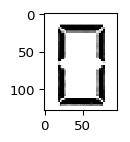

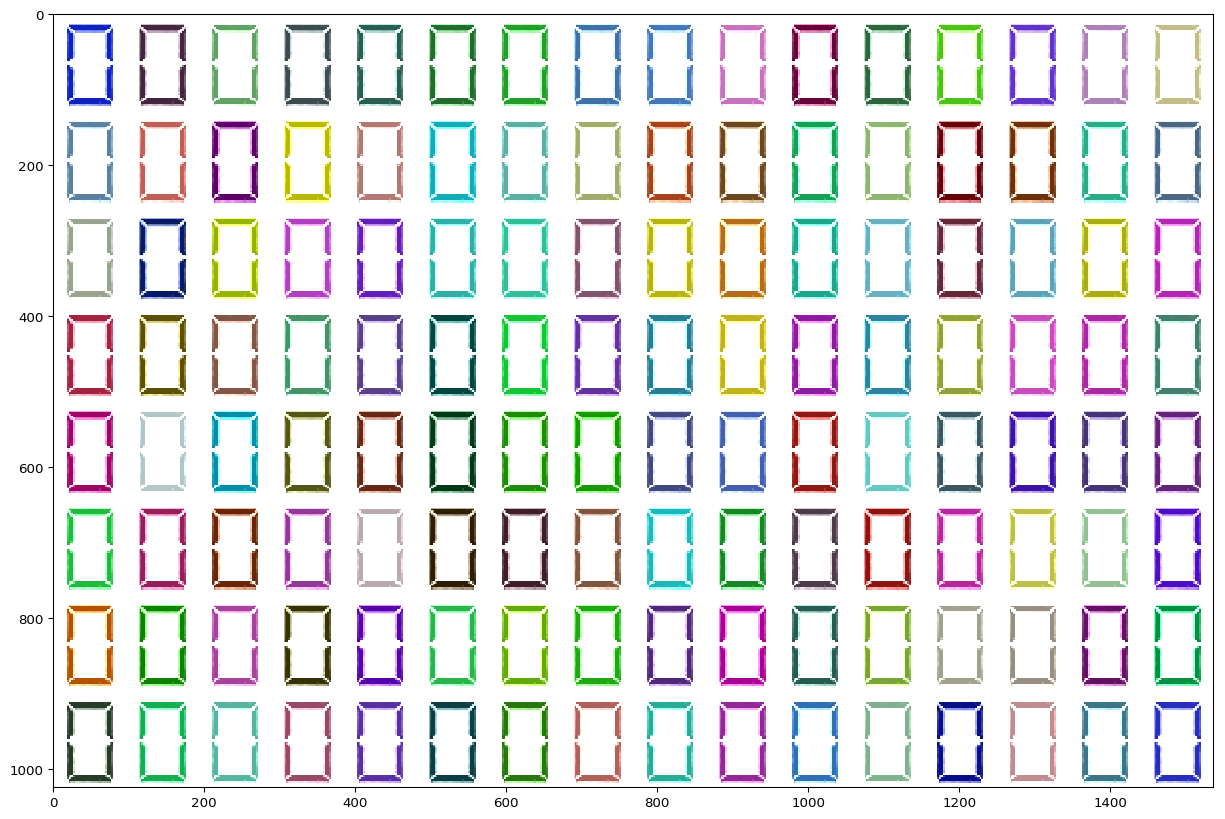

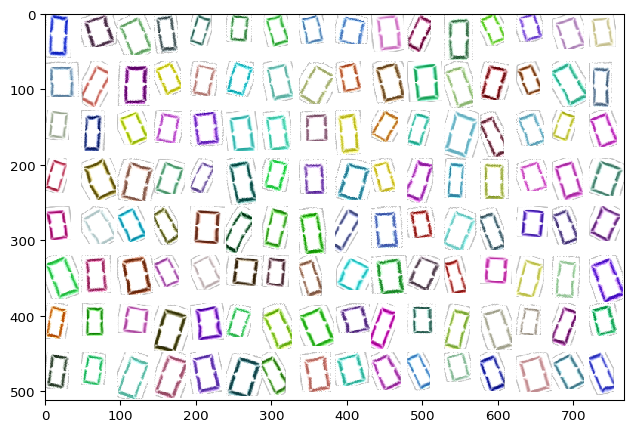

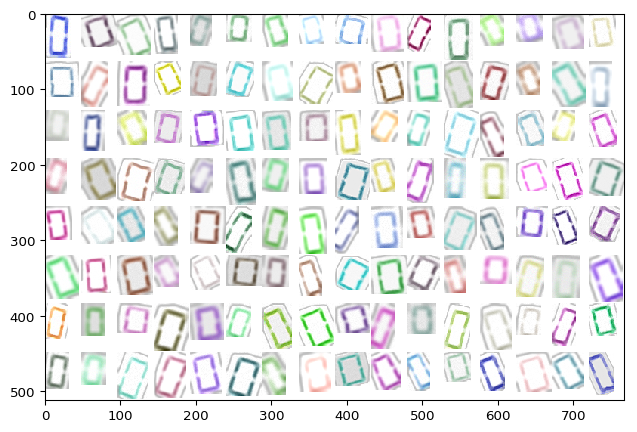

Original: (128, 96, 4)


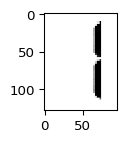

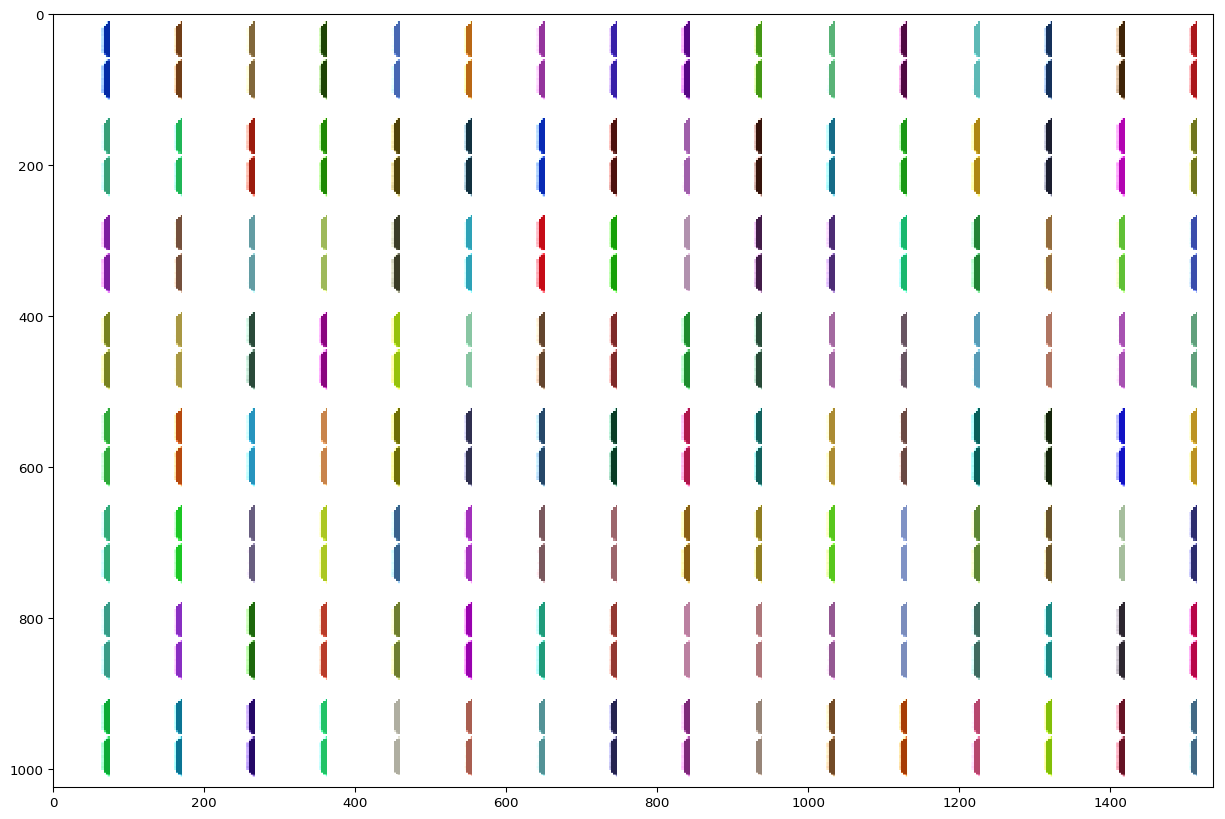

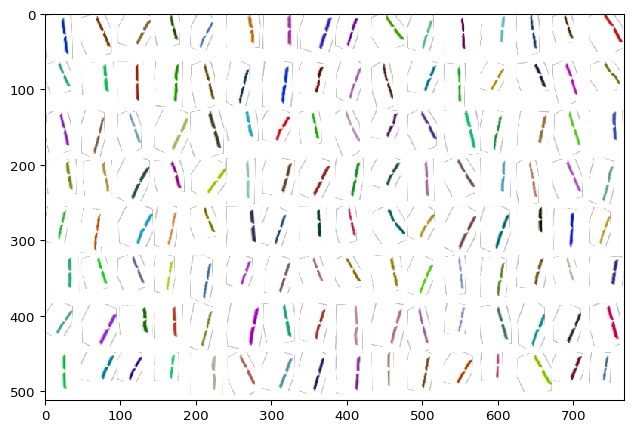

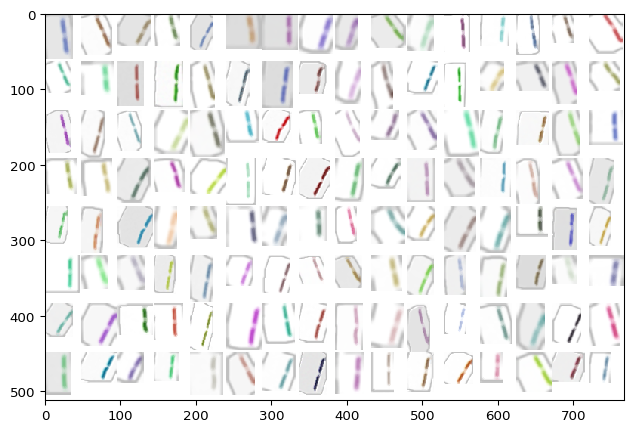

Original: (128, 96, 4)


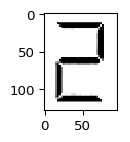

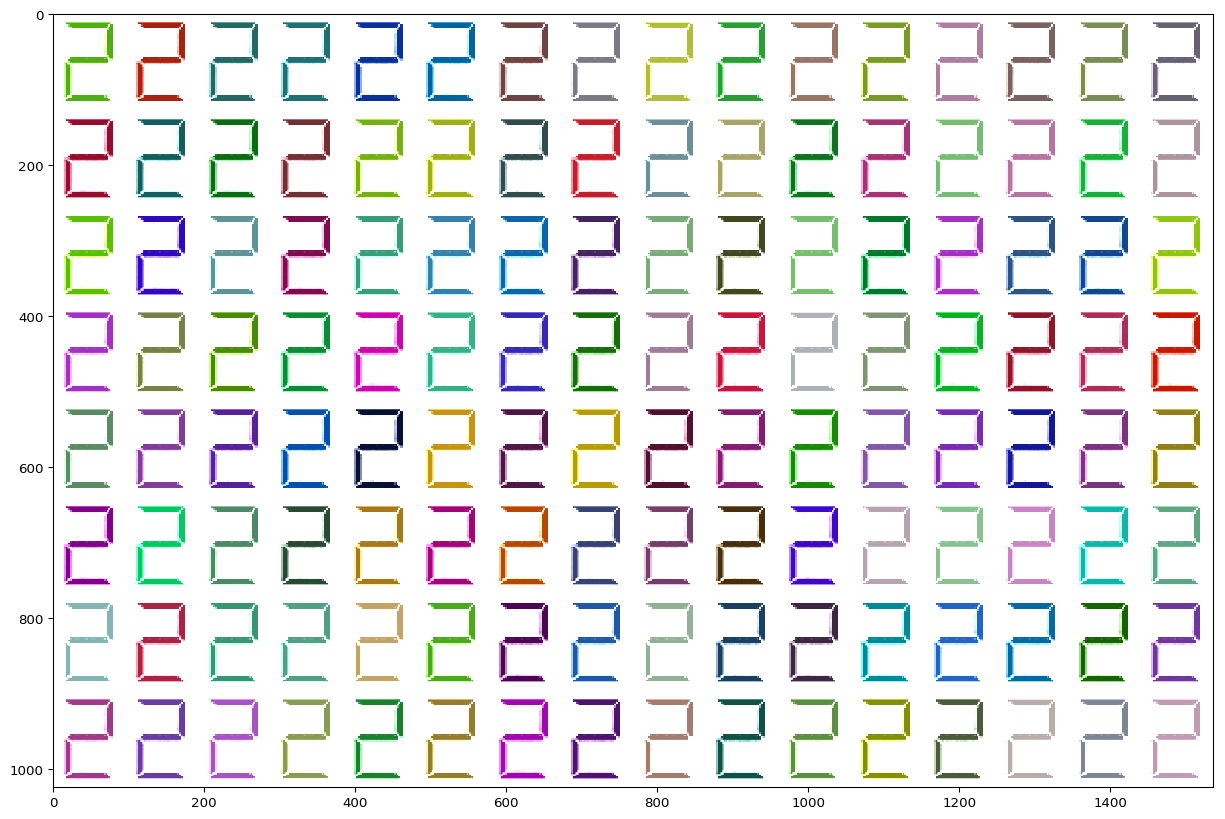

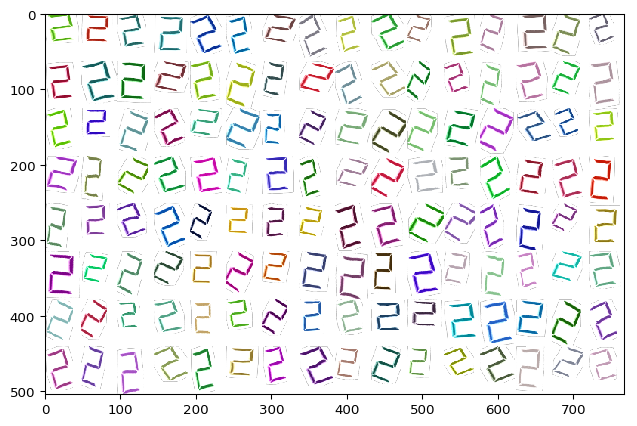

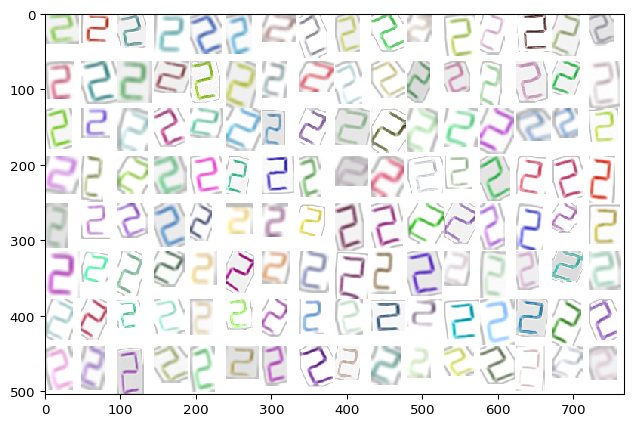

Original: (128, 96, 4)


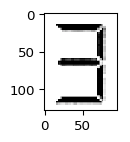

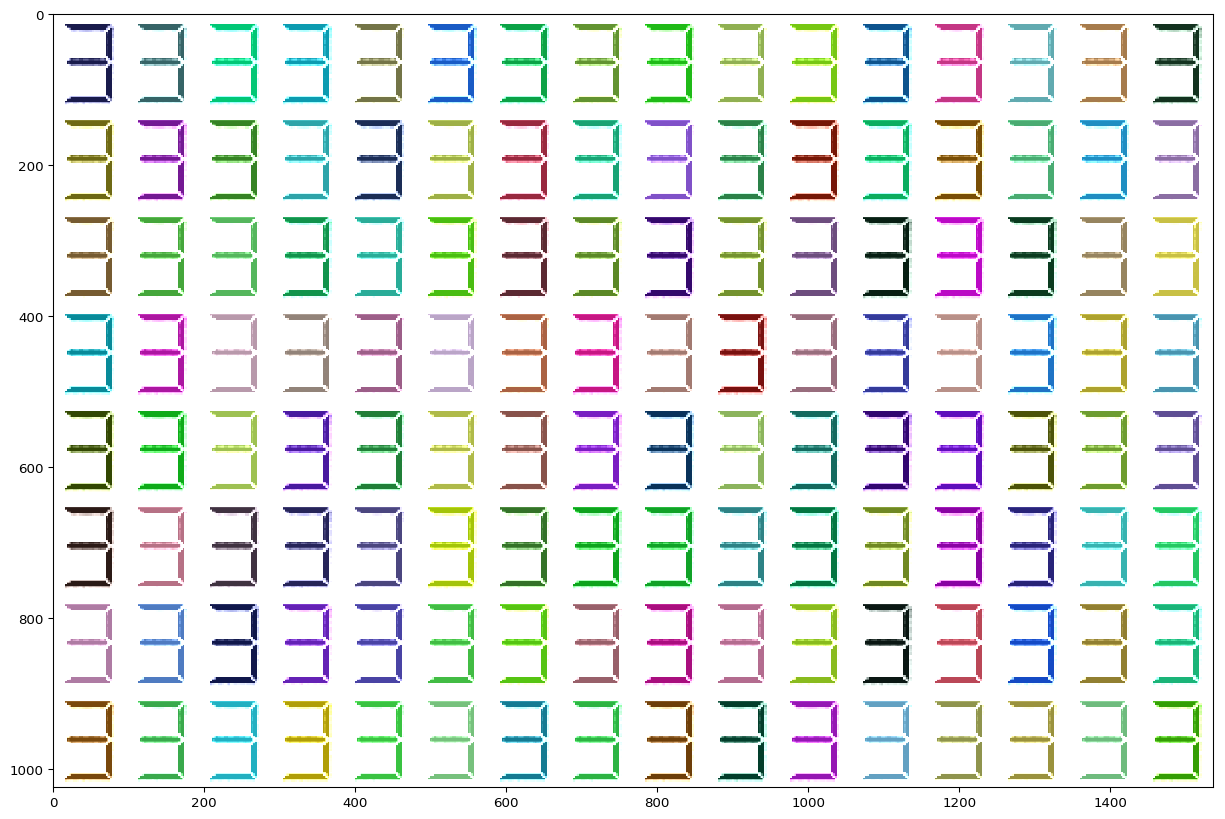

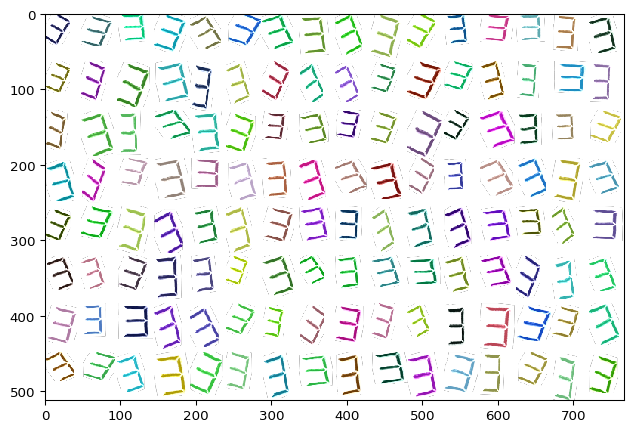

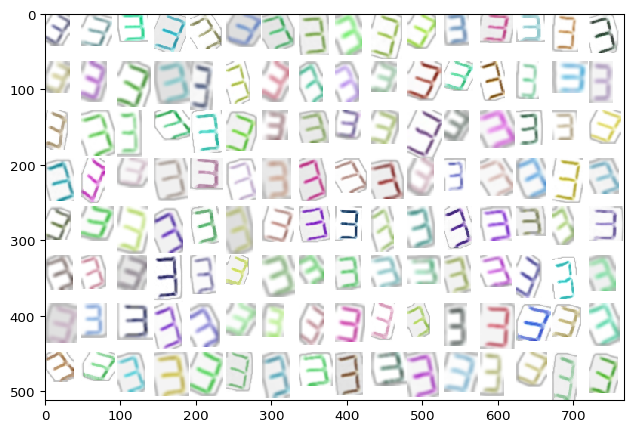

Original: (128, 96, 4)


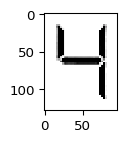

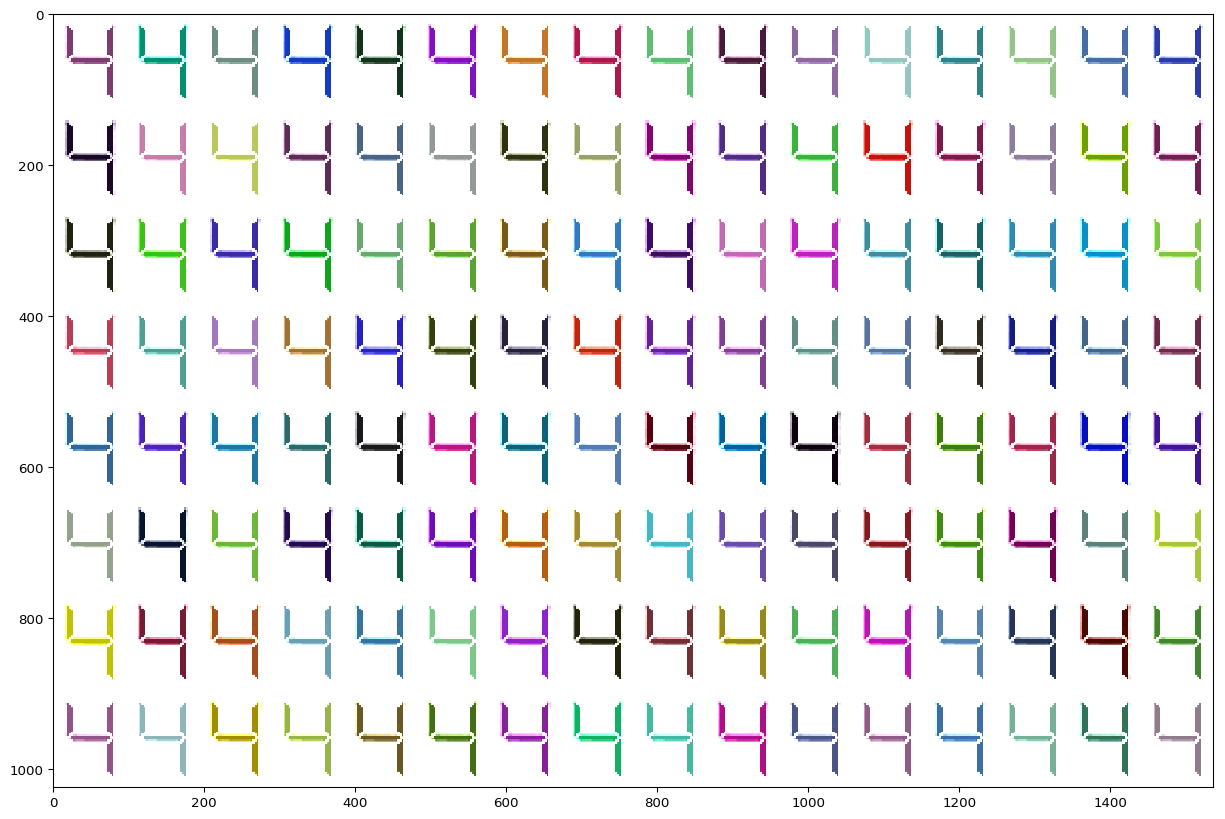

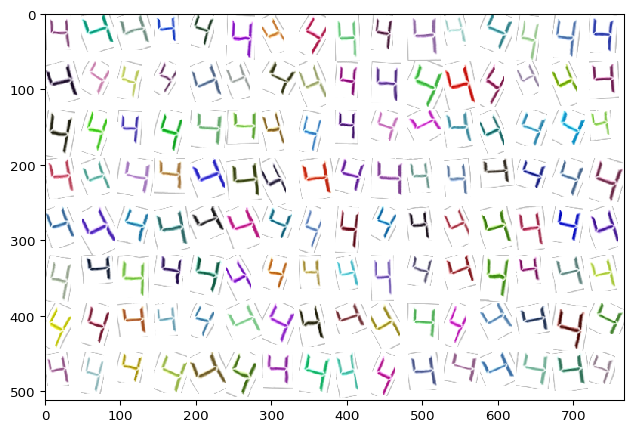

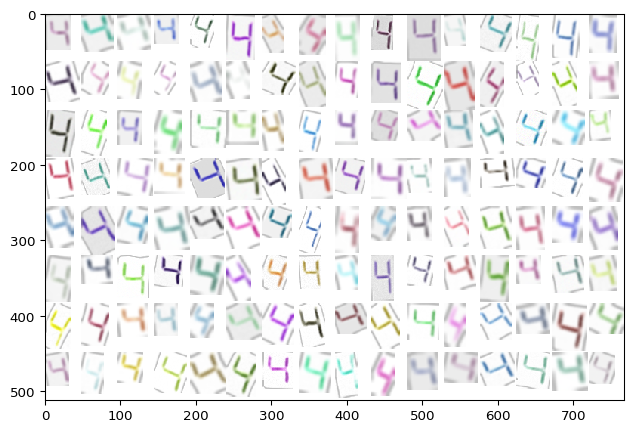

Original: (128, 96, 4)


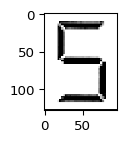

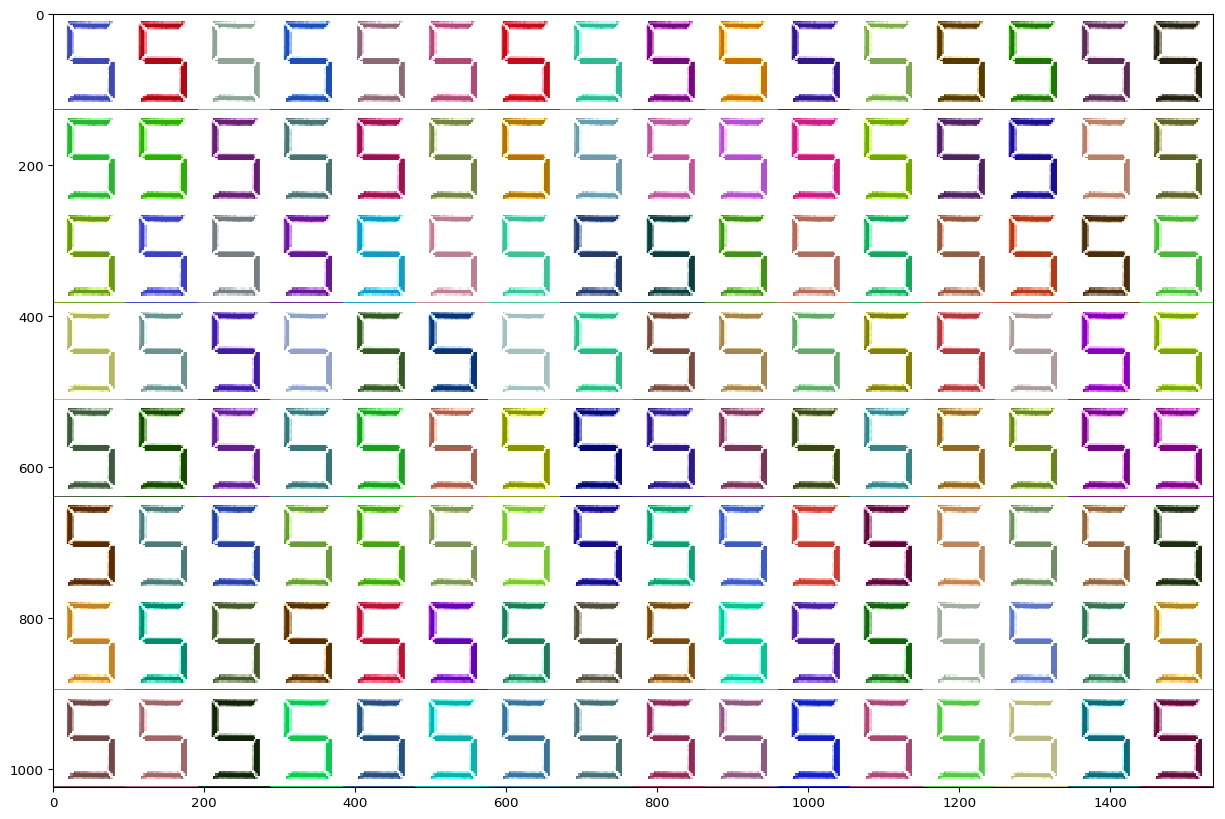

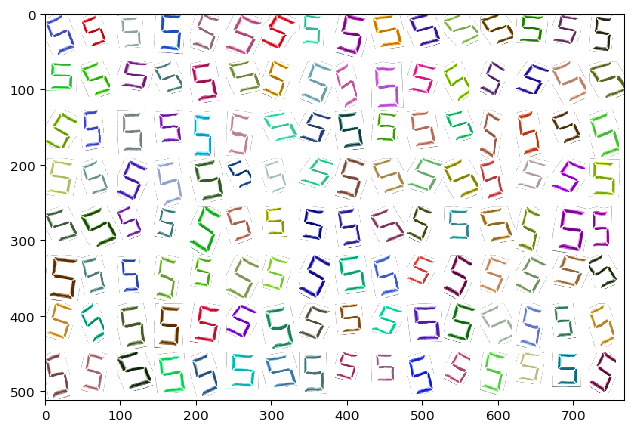

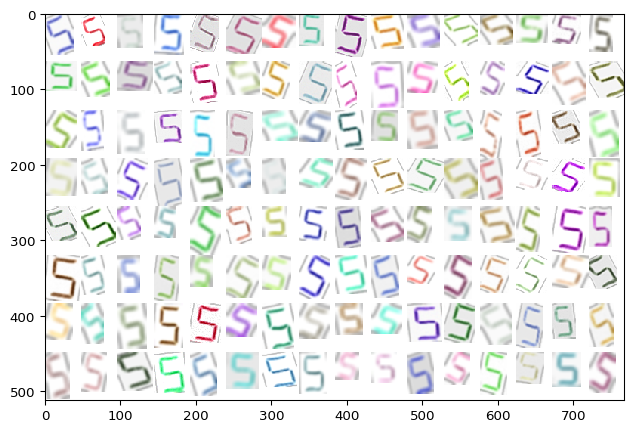

Original: (128, 96, 4)


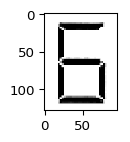

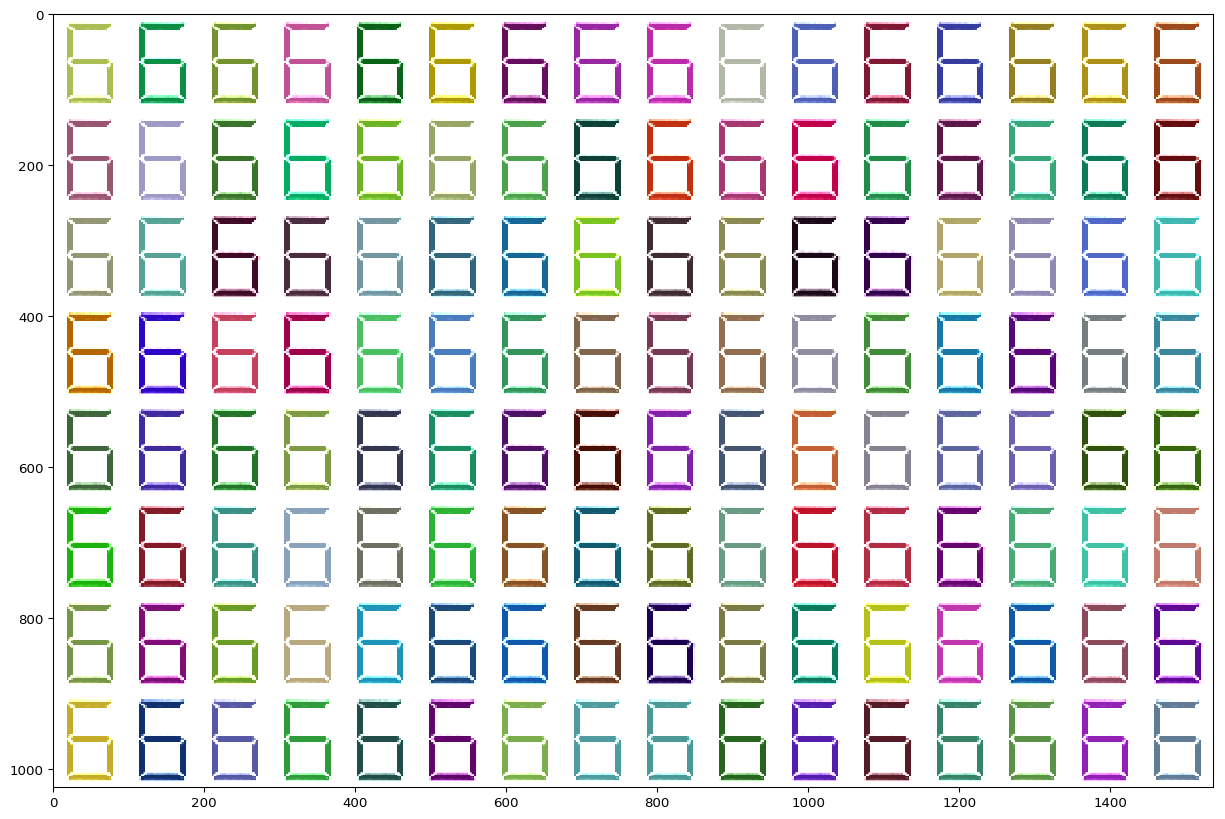

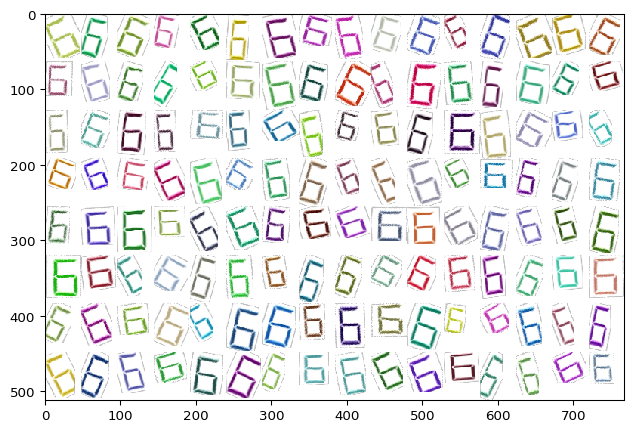

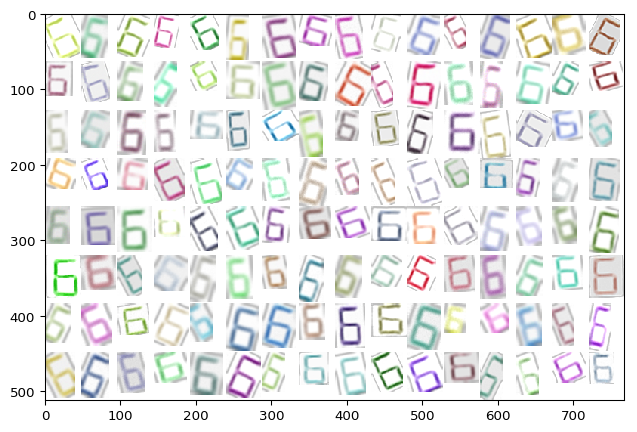

Original: (128, 96, 4)


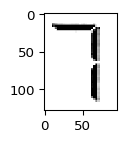

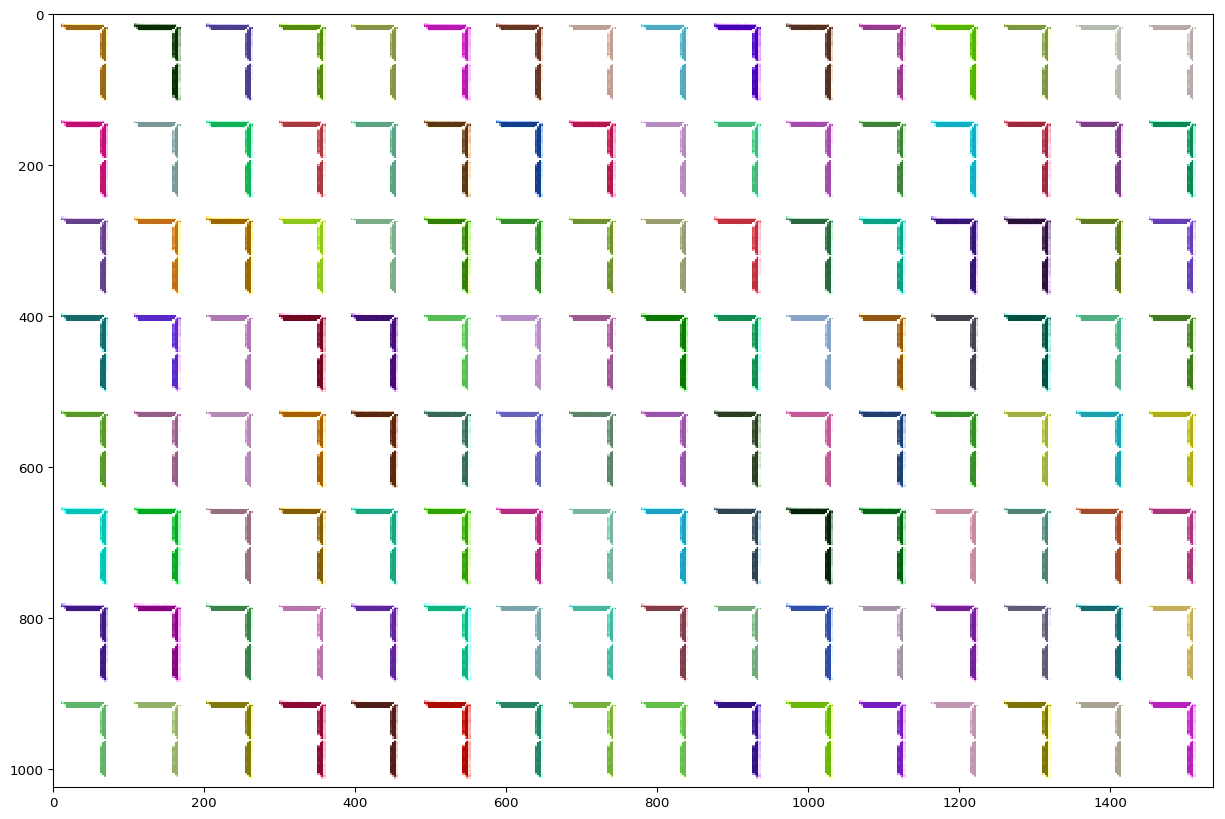

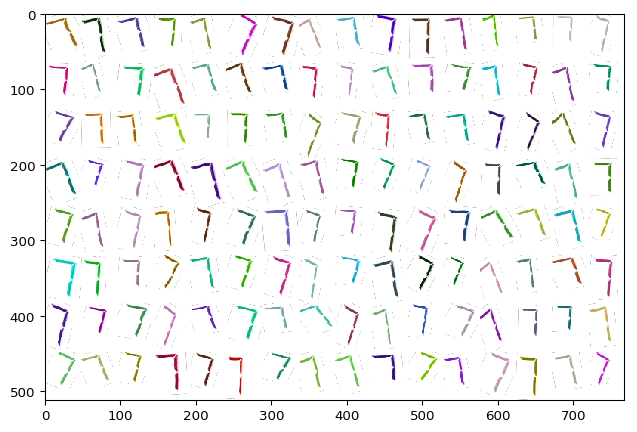

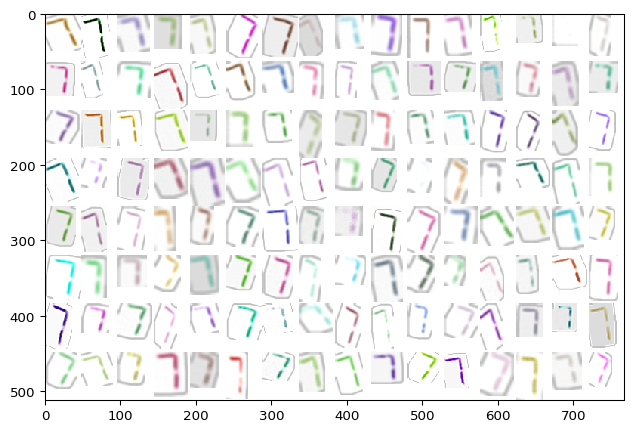

Original: (128, 96, 4)


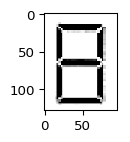

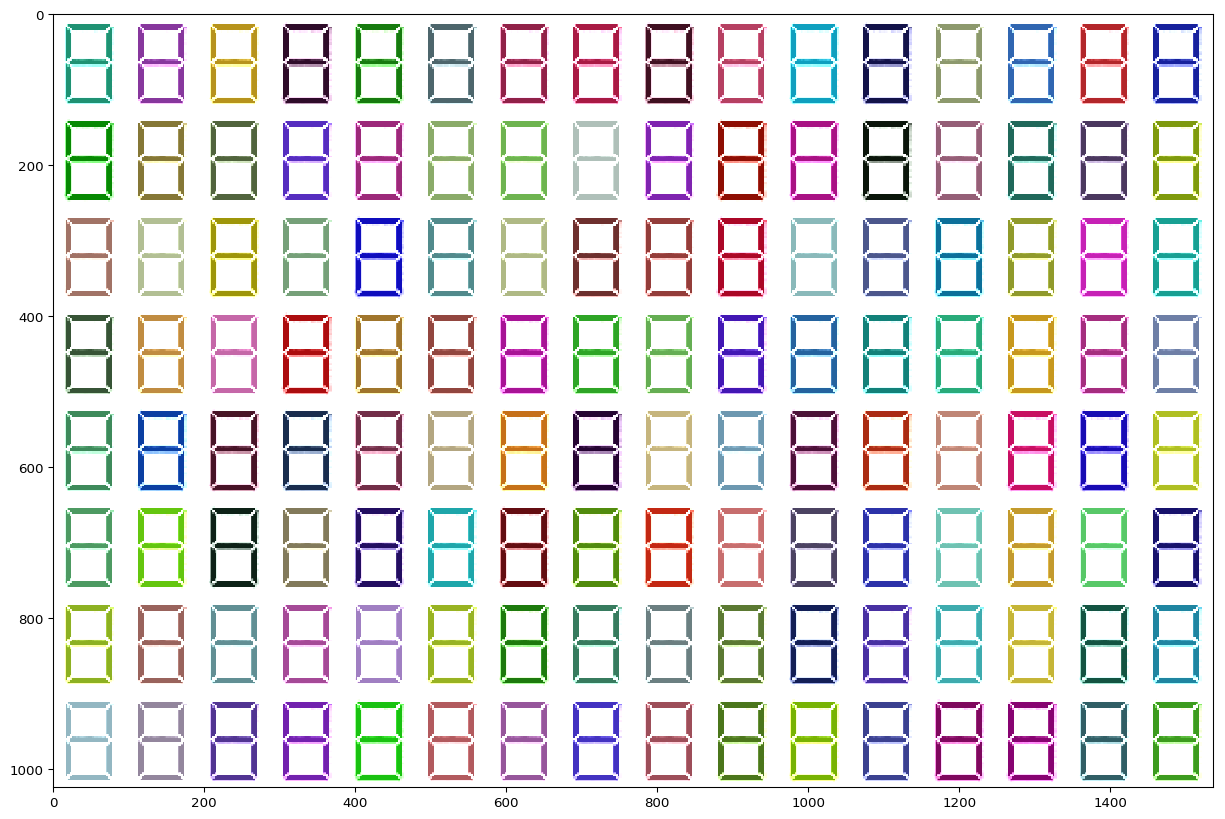

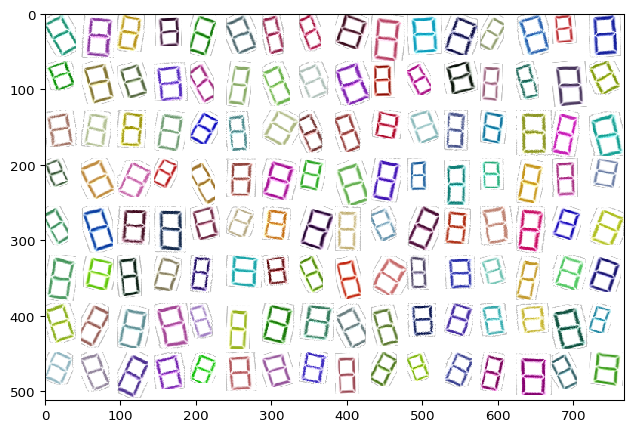

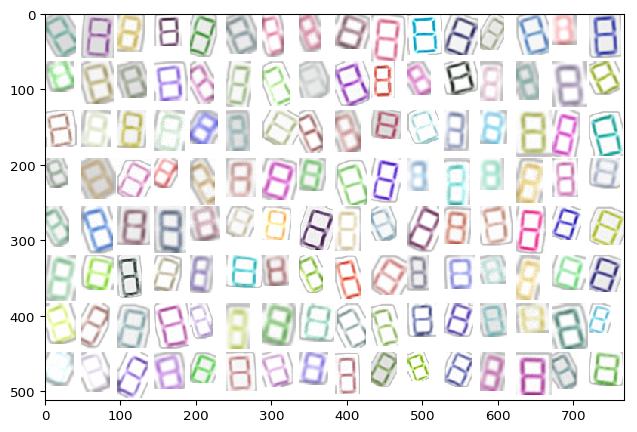

Original: (128, 96, 4)


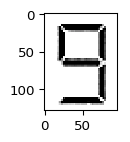

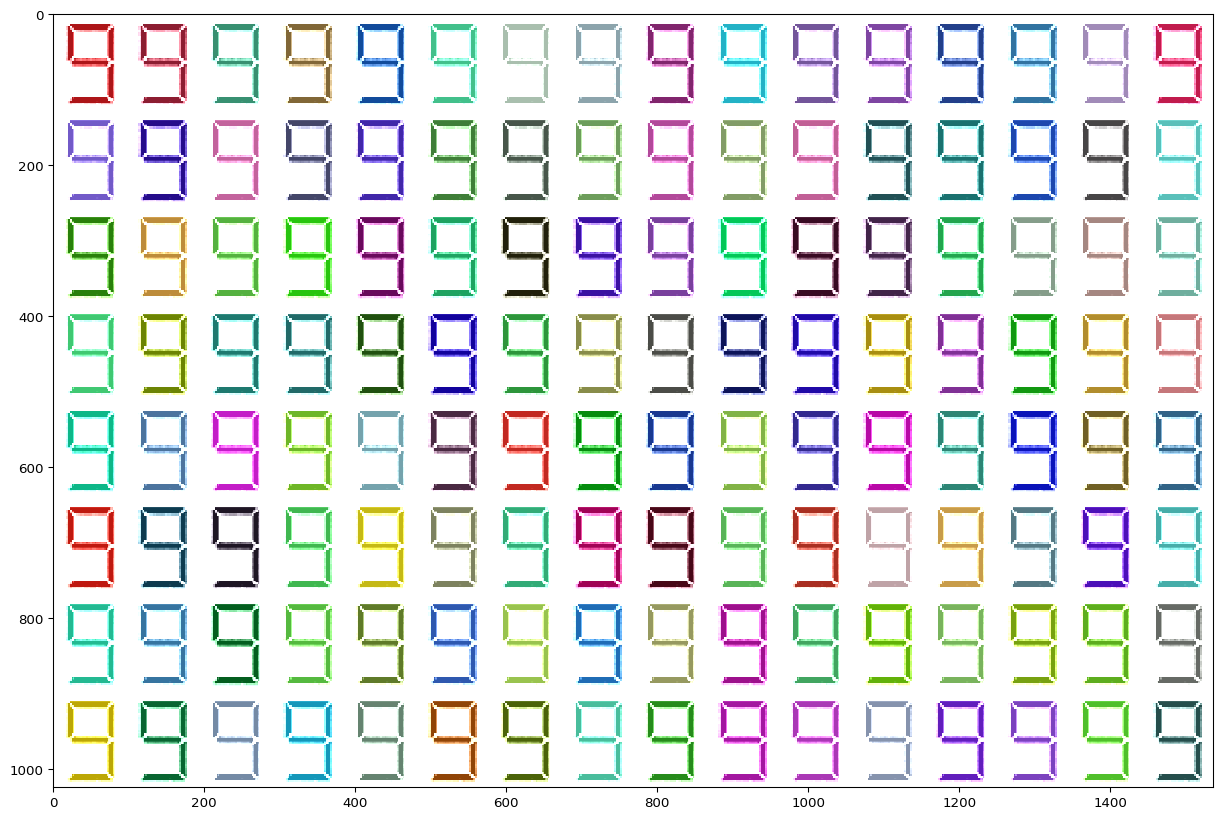

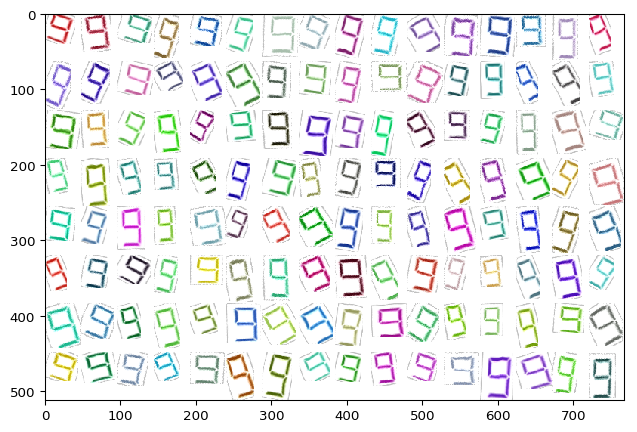

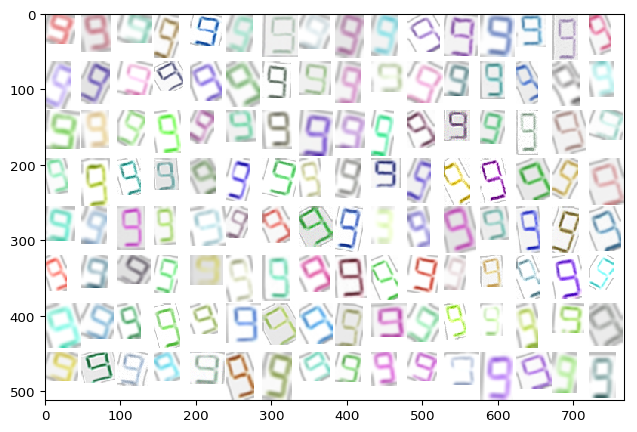

In [48]:
os.chdir(digit_dir)

for i in range (10):
    augmentation = distortion(trans(coloring(i)))
    save(augmentation, i)

In [54]:
# check if successful generate:
number_of_files = len([item for item in os.listdir(des_dir) if os.path.isfile(os.path.join(des_dir,item))])
if number_of_files != (sample * 10 + 10 + 1) :
    print ("Error occurs in image augmentation !")
print (number_of_files-1, "files in", des_dir)

1290 files in /Users/missbamboo/Desktop/intel/ocr/ocr-digital-display/VOC2007/JPEGImages
